In [ ]:
import torch
import clip
from PIL import Image
import torch.nn.functional as F


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

image = preprocess(Image.open("2.jpg")).unsqueeze(0).to(device) # CLIP.png为本文中图一，即CLIP的流程图
text = clip.tokenize([
    'a photo of a woman', 
    'a photo of a man', 
    'a photo of a pair of shoes', 
    'a photo of a car',
    'a photo of a flower'
]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image) # 将图片进行编码
    text_features = model.encode_text(text)    # 将文本进行编码

    image_features = F.normalize(image_features, p=2, dim=-1)
    text_features = F.normalize(text_features, p=2, dim=-1)
    
    cosine_similarity = (image_features @ text_features.T).squeeze(0)
    
    logit_scale = model.logit_scale.exp()
    scaled_logits = logit_scale * cosine_similarity
    
    probs = F.softmax(scaled_logits, dim=0).cpu().numpy()

print("Cosine similarity scores:", cosine_similarity.cpu().numpy())
print("Label probs:", probs)

In [ ]:
from model.CLIP import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
model.eval()


In [ ]:
import clip
import torch
import types
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) 加载 CLIP 模型（就是你 pip 装的那个）
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
model.eval()

# 2) 准备一个列表存所有层的注意力
attn_maps = []

# 3) 定义新的 attention 函数，替换 ResidualAttentionBlock.attention
def attention_with_weights(self, x: torch.Tensor):
    """
    x: [L, N, C]  (L = tokens, N = batch)
    """
    # 保持原来的 mask 逻辑
    if self.attn_mask is not None:
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device)

    # 关键：need_weights=True, average_attn_weights=False → 得到 [N, H, L, L]
    out, weights = self.attn(
        x, x, x,
        need_weights=True,
        attn_mask=self.attn_mask,
        average_attn_weights=False,
    )
    # 保存注意力权重 (CPU 上存)
    attn_maps.append(weights.detach().cpu())  # [N, heads, L, L]

    return out

# 4) 把视觉 Transformer 的所有 ResidualAttentionBlock.attention 替换掉
# VisionTransformer 在 model.visual 里
for block in model.visual.transformer.resblocks:
    block.attention = types.MethodType(attention_with_weights, block)

# 5) 跑一张图，触发前向 + 收集注意力
img = preprocess(Image.open("1.jpg")).unsqueeze(0).to(device)

with torch.no_grad():
    _ = model.encode_image(img)   # 这里会走到我们改过的 attention()

print("num layers:", len(attn_maps))
print("shape of one layer:", attn_maps[0].shape)
# 期望输出:
# num layers: 12
# shape of one layer: torch.Size([1, 12, 197, 197])


import torch.nn.functional as F
import matplotlib.pyplot as plt

# 取最后一层的注意力
attn_last = attn_maps[-1]          # [1, 12, 197, 197]
attn_last = attn_last[0]           # [12, 197, 197]  heads, L, L

# 平均所有 head
attn_mean = attn_last.mean(0)      # [197, 197]

# 取 CLS → patch 的注意力（CLS 是 token 0，patch 从 1 开始）
cls_to_patches = attn_mean[0, 1:]          # [196]
cls_to_patches = cls_to_patches.reshape(14, 14)  # 14x14 网格

# 归一化到 [0,1]
cls_norm = (cls_to_patches - cls_to_patches.min()) / (cls_to_patches.max() - cls_to_patches.min() + 1e-6)

# 上采样到 224x224，方便和原图对齐
heatmap = F.interpolate(
    cls_norm.unsqueeze(0).unsqueeze(0),  # [1,1,14,14]
    size=(224, 224),
    mode="bilinear",
    align_corners=False
).squeeze().numpy()

# 可视化叠加
orig = Image.open("2.jpg").resize((224,224))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(orig)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("CLS→Patch Attention")
plt.tight_layout()
plt.show()


In [1]:
from model.CLIP import *
import torch
from model.backbone_prompt import make_model

# 1) load CLIP
clip_model, _ = clip.load("ViT-B/16", device="cuda")
class EasyCFG:
    class MODEL:
        NAME = "ViT-B/16"
        NECK = "bnneck"
        COS_LAYER = False

        # ---- SIE 配置 ----
        SIE_CAMERA = False
        SIE_VIEW = False
        SIE_COE = 3.0 

        # ---- 视觉编码器 stride ----
        STRIDE_SIZE = (16, 16)

        # ---- Prompt Mask ----
        MASK_PROB = 0.2

        # ---- CAA 残差校正 ----
        CAA_GAMMA = 0.5

    class INPUT:
        SIZE_TRAIN = (256, 128)

    class DATASETS:
        NAMES = ["LTCC"]  

    class TEST:
        NECK_FEAT = "after"

cfg = EasyCFG()

num_class = 45
camera_num = 1
view_num = 1

# 3) 构造模型
model = make_model(cfg, num_class, camera_num, view_num).cuda().eval()

# 4) 读取 prompt learner
prompt_learner = model.prompt_learner

print("cls_ctx shape:", prompt_learner.cls_ctx.shape)
print("prefix shape:", prompt_learner.token_prefix.shape)
print("suffix shape:", prompt_learner.token_suffix.shape)


e:\anaconda3\envs\CT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\anaconda3\envs\CT\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


AttributeError: 'EasyCFG' object has no attribute 'DATA'

In [ ]:
from model.backbone_prompt import PromptLearner
prompts, readable = model.prompt_learner.visualize_prompts()

In [ ]:
masked_readable = model.prompt_learner.visualize_masked_prompts(model)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
from model.backbone_prompt import build_transformer

text_emb = model.get_text_embeddings(masked=False)
text_emb_mask = model.get_text_embeddings(masked=True)

N = text_emb.shape[0]
labels = np.arange(N)

from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(text_emb, text_emb_mask)
plt.imshow(sim)
plt.colorbar()


# pca = PCA(n_components=2)
# emb_pca = pca.fit_transform(text_emb)

# # tsne = TSNE(n_components=2, perplexity=10, n_iter=2000)
# # emb_tsne = tsne.fit_transform(text_emb)


# plt.figure(figsize=(6,5))
# plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=labels, cmap='tab10', s=80)

# for i in range(N):
#     plt.text(emb_tsne[i,0], emb_tsne[i,1], f"C{i}", fontsize=9)

# plt.title("PCA of Text Embeddings")
# plt.show()


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# # ------------------------
# # 1) 获取文本 embedding
# # ------------------------
# text_emb = model.get_text_embeddings(masked=False)   
# text_emb_mask = model.get_text_embeddings(masked=True)

# def to_numpy(x):
#     if isinstance(x, torch.Tensor):
#         return x.detach().cpu().numpy()
#     elif isinstance(x, np.ndarray):
#         return x
#     else:
#         raise ValueError("Unsupported type:", type(x))

# X1 = to_numpy(text_emb)
# X2 = to_numpy(text_emb_mask)


# C = X1.shape[0]

# # ------------------------
# # 2) 拼接用于 t-SNE
# # ------------------------
# X = np.concatenate([X1, X2], axis=0)  # (2C, 512)

# # 标签：
# labels = np.concatenate([
#     np.arange(C),    # unmasked 类 ID
#     np.arange(C)     # masked 同样类 ID
# ])

# domain = np.array([0]*C + [1]*C)  
# # domain=0 → unmasked，domain=1 → masked

# # ------------------------
# # 3) t-SNE 降维
# # ------------------------
# tsne = TSNE(
#     n_components=2,
#     perplexity=15,
#     learning_rate='auto',
#     init='pca',
#     max_iter=2000
# )

# X_tsne = tsne.fit_transform(X)  # (2C, 2)

# # ------------------------
# # 4) 绘图（论文级别）
# # ------------------------
# plt.figure(figsize=(8,7))

# # unmasked
# plt.scatter(
#     X_tsne[:C,0], X_tsne[:C,1],
#     c=labels[:C], cmap='tab20',
#     marker='o', s=70, label="unmasked"
# )

# # masked
# plt.scatter(
#     X_tsne[C:,0], X_tsne[C:,1],
#     c=labels[C:], cmap='tab20',
#     marker='x', s=70, label="masked"
# )

# # 标注
# for i in range(C):
#     plt.text(X_tsne[i,0],     X_tsne[i,1],     f"C{i}", fontsize=8)
#     plt.text(X_tsne[i+C,0],   X_tsne[i+C,1],   f"C{i}", fontsize=8)

# plt.legend()
# plt.title("t-SNE of Text Embeddings (unmasked vs masked)", fontsize=15)
# plt.grid(alpha=0.3)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# --- 1. numpy 处理 ---
def to_numpy(x):
    import torch
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

text_emb = to_numpy(model.get_text_embeddings(masked=False))
text_emb_mask = to_numpy(model.get_text_embeddings(masked=True))

C = text_emb.shape[0]

# --- 2. 拼接 t-SNE 输入 ---
X = np.concatenate([text_emb, text_emb_mask], axis=0)

tsne = TSNE(
    n_components=2,
    perplexity=20,
    init='pca',
    learning_rate='auto',
    max_iter=2000
)
X_tsne = tsne.fit_transform(X)

# --- 3. 分离 unmask / mask ---
U = X_tsne[:C]
M = X_tsne[C:]

# --- 4. 画连线版本 ---
plt.figure(figsize=(10, 8))

for i in range(C):
    # 连线
    plt.plot([U[i,0], M[i,0]], [U[i,1], M[i,1]],
             c='gray', alpha=0.5, linewidth=1)
    
    # unmasked ●
    plt.scatter(U[i,0], U[i,1],
                c='blue', s=40)
    
    # masked ×
    plt.scatter(M[i,0], M[i,1],
                c='red', marker='x', s=40)

plt.title("t-SNE with Line Connections (unmasked → masked)", fontsize=16)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported type:", type(x))

# 1) 获取 embedding
text_emb = to_numpy(model.get_text_embeddings(masked=False))   # (C, 512)
text_emb_mask = to_numpy(model.get_text_embeddings(masked=True))

C = text_emb.shape[0]

# 2) 用 unmasked 训练 PCA
pca = PCA(n_components=2)
pca.fit(text_emb)

U = pca.transform(text_emb)        # unmasked in 2D, (C, 2)
M = pca.transform(text_emb_mask)   # masked in SAME PCA space

# 3) 画箭头图
plt.figure(figsize=(10, 8))

for i in range(C):
    # 箭头：unmasked -> masked
    plt.arrow(
        U[i,0], U[i,1],
        M[i,0]-U[i,0], M[i,1]-U[i,1],
        length_includes_head=True,
        head_width=0.15, head_length=0.3,
        fc='gray', ec='gray', alpha=0.6
    )
    # 起点：unmasked
    plt.scatter(U[i,0], U[i,1], c='blue', s=40)
    # 终点：masked
    plt.scatter(M[i,0], M[i,1], c='red', marker='x', s=40)

plt.title("PCA of Text Embeddings with Arrows (unmasked → masked)", fontsize=16)
plt.grid(alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

text = model.get_text_embeddings(masked=False)
text_m = model.get_text_embeddings(masked=True)

# ---- 计算真实变化（高维） ----
cos_sim = np.sum(text * text_m, axis=1) / (
    np.linalg.norm(text,axis=1) * np.linalg.norm(text_m,axis=1)
)

shift = 1 - cos_sim     # 真实余弦距离变化
print("mean perturbation:", shift.mean())
print("max perturbation:", shift.max())
print("min perturbation:", shift.min())


In [ ]:
from config import cfg
print(cfg.MODEL.DEVICE_ID, type(cfg.MODEL.DEVICE_ID))


In [1]:
import os, sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 确保能 import 你工程
PROJ_ROOT = "/home/jin/code/text"
if PROJ_ROOT not in sys.path:
    sys.path.insert(0, PROJ_ROOT)

YML_PATH   = "/home/jin/code/text/configs/last/ViT-16.yml"
CKPT_PATH  = "/home/jin/code/text/logs/vit16_last/model_best.pth"  # 例如: ""；为空则不加载

DEVICE_ID = 0
device = torch.device(f"cuda:{DEVICE_ID}" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda:0


In [4]:
from yacs.config import CfgNode as CN

def _ensure(cfg, key, value):
    parts = key.split(".")
    node = cfg
    for p in parts[:-1]:
        if p not in node:
            node[p] = CN()
        node = node[p]
    if parts[-1] not in node:
        node[parts[-1]] = value

def load_cfg_like_train(yml_path):
    """
    尽量复现 train.py 的 cfg 构建方式：defaults -> merge yml -> freeze
    """
    cfg = None

    # 你工程常见的几种 defaults 入口（逐个尝试）
    tried = []
    for mod, attr in [
        ("config.defaults", "get_cfg_defaults"),
        ("configs.defaults", "get_cfg_defaults"),
        ("config", "cfg"),
        ("configs", "cfg"),
    ]:
        try:
            m = __import__(mod, fromlist=[attr])
            obj = getattr(m, attr)
            cfg = obj() if callable(obj) else obj.clone()
            break
        except Exception as e:
            tried.append((mod, attr, str(e)))

    # fallback：没有 defaults 时用空 cfg，但会补齐关键字段避免 AttributeError
    if cfg is None:
        cfg = CN(new_allowed=True)

    cfg.merge_from_file(yml_path)

    # 兜底补字段（避免 notebook 场景缺字段）
    _ensure(cfg, "MODEL.COS_LAYER", False)
    _ensure(cfg, "MODEL.NECK", "bnneck")
    _ensure(cfg, "TEST.NECK_FEAT", "after")
    _ensure(cfg, "MODEL.DIST_TRAIN", False)

    # 你现在要可视化 attn-guided mask：这里强制打开（不影响你训练代码，只是 notebook 可视化）
    cfg.defrost()
    _ensure(cfg, "MODEL.USE_ATTN_MASK", True)
    _ensure(cfg, "MODEL.ATTN_MASK_RATIO", 0.5)  # 你想 mask 的比例
    _ensure(cfg, "MODEL.MASK_PROB", 1.0)        # notebook 可视化可设 1.0，保证每次都触发（训练时你自己再改回去）
    cfg.MODEL.USE_ATTN_MASK = True
    cfg.freeze()

    return cfg

cfg = load_cfg_like_train(YML_PATH)
print("USE_ATTN_MASK =", cfg.MODEL.USE_ATTN_MASK, "ATTN_MASK_RATIO =", cfg.MODEL.ATTN_MASK_RATIO)
print("INPUT.SIZE_TRAIN =", cfg.INPUT.SIZE_TRAIN)


USE_ATTN_MASK = True ATTN_MASK_RATIO = 0.5
INPUT.SIZE_TRAIN = (256, 128)


In [5]:
from model.backbone_prompt import make_model

# PRCC 的 num_classes/cam/view 你自己按真实值填；只用于构建分类头维度
NUM_CLASS = 221  # PRCC 常见 221（如果你不确定，先填你训练时的 num_classes）
CAM_NUM   = 2
VIEW_NUM  = 1

model = make_model(cfg, NUM_CLASS, CAM_NUM, VIEW_NUM).to(device)
model.eval()

if CKPT_PATH and os.path.isfile(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    state = ckpt.get("model", ckpt)  # 兼容你保存的是 {"model":...} 或直接 state_dict
    missing, unexpected = model.load_state_dict(state, strict=False)
    print("loaded ckpt:", CKPT_PATH)
    print("missing:", len(missing), "unexpected:", len(unexpected))
else:
    print("no ckpt loaded (CKPT_PATH empty or not found)")


/home/jin/miniconda3/envs/CT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jin/miniconda3/envs/CT/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


RuntimeError: Error(s) in loading state_dict for build_transformer:
	size mismatch for classifier.weight: copying a param with shape torch.Size([5000, 768]) from checkpoint, the shape in current model is torch.Size([221, 768]).
	size mismatch for classifier_proj.weight: copying a param with shape torch.Size([5000, 512]) from checkpoint, the shape in current model is torch.Size([221, 512]).
	size mismatch for prompt_learner.cls_ctx: copying a param with shape torch.Size([5000, 16, 512]) from checkpoint, the shape in current model is torch.Size([221, 16, 512]).
	size mismatch for prompt_learner.cls_ctx_init: copying a param with shape torch.Size([5000, 16, 512]) from checkpoint, the shape in current model is torch.Size([221, 16, 512]).

In [6]:
img = None
pid = None

# 1) 尝试从你的工程 dataloader 里拿一张（如果 import 路径不一致会自动跳过）
try:
    from .data.dataloader import make_dataloader  # 你工程常见命名，若不同你自己改一下
    train_loader, _, num_query, num_classes, camera_num, view_num = make_dataloader(cfg)
    batch = next(iter(train_loader))
    # 你工程 batch 可能是 (img, pid, camid, viewid, ...) 或 dict，下面做兼容
    if isinstance(batch, (list, tuple)):
        img = batch[0]
        pid = batch[1]
    elif isinstance(batch, dict):
        img = batch["img"]
        pid = batch["pid"]
    print("loaded a real batch from dataloader:", img.shape, pid.shape)
except Exception as e:
    print("dataloader not used, fallback to random image. reason:", repr(e))

# 2) fallback：随机图（尺寸对齐你的训练输入）
if img is None:
    H, W = cfg.INPUT.SIZE_TRAIN
    img = torch.randn(1, 3, H, W)
    pid = torch.zeros(1, dtype=torch.long)

# 只取 1 张做可视化
img = img[:1].to(device)
pid = pid[:1].to(device).long()
print("using img:", tuple(img.shape), "pid:", pid.item())


dataloader not used, fallback to random image. reason: ImportError('attempted relative import with no known parent package')
using img: (1, 3, 256, 128) pid: 0


[LaST attn-guided text mask] ctx_len=16, masked=8/16, mask_ratio=0.500
CTX: <CTX-0> <MASK> <CTX-2> <MASK> <MASK> <CTX-5> <CTX-6> <CTX-7> <MASK> <CTX-9> <MASK> <MASK> <CTX-12> <CTX-13> <MASK> <MASK>


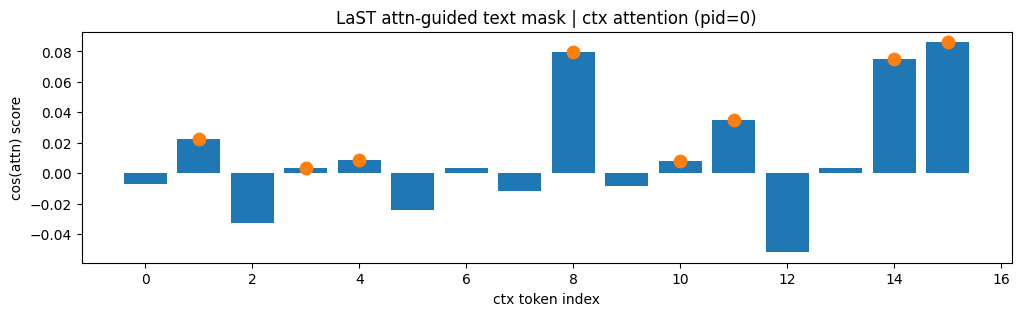

masked token norm(after)  min/mean/max: 0.0 0.22954614 0.48575124


In [8]:
@torch.no_grad()
def visualize_attn_guided_text_mask(model, pid, img, title="attn-guided mask"):
    """
    可视化：
    - ctx_attn 分数（prefix/suffix 不画，只画 cls_ctx）
    - 被 mask 的 ctx token（top-k）
    - 打印 prompt 结构（<CTX-i> / <MASK>）
    """
    pl = model.prompt_learner

    # 1) 生成未 mask 的 prompts
    prompts = pl(pid, mask_mode="none")  # [B,L,C]

    # 2) 用图像特征引导 mask（用 feat_proj，与你 forward 中一致）
    _, _, _, feat_proj = model.dummy_forward_image(img)  # 返回 img_feature, img_feature_proj, feat, feat_proj
    prompts_masked, attn, mask_bool = model.apply_attn_guided_mask(prompts, feat_proj)

    prefix_len = pl.token_prefix.shape[1]
    ctx_len    = pl.cls_ctx.shape[1]
    suffix_len = pl.token_suffix.shape[1]

    ctx_attn = attn[0, prefix_len:prefix_len+ctx_len].float().cpu().numpy()
    ctx_mask = mask_bool[0, prefix_len:prefix_len+ctx_len].bool().cpu().numpy()
    mask_ratio = float(ctx_mask.mean())

    # 3) 打印结构（只打印 ctx 部分更直观）
    readable = []
    for i in range(ctx_len):
        readable.append("<MASK>" if ctx_mask[i] else f"<CTX-{i}>")
    print(f"[{title}] ctx_len={ctx_len}, masked={ctx_mask.sum()}/{ctx_len}, mask_ratio={mask_ratio:.3f}")
    print("CTX:", " ".join(readable))

    # 4) 画图：注意力分数 + mask 标记
    x = np.arange(ctx_len)

    plt.figure(figsize=(12, 3))
    plt.bar(x, ctx_attn)
    plt.title(f"{title} | ctx attention (pid={int(pid.item())})")
    plt.xlabel("ctx token index")
    plt.ylabel("cos(attn) score")

    # 用红圈标出被 mask 的 token
    masked_idx = np.where(ctx_mask)[0]
    plt.scatter(masked_idx, ctx_attn[masked_idx], s=80, marker="o")
    plt.show()

    # 5) sanity check：mask 后 token 是否真的被置零（只查 ctx 区域）
    ctx_before = prompts[0, prefix_len:prefix_len+ctx_len].float()
    ctx_after  = prompts_masked[0, prefix_len:prefix_len+ctx_len].float()
    # 被 mask 的 token 向量范数应接近 0
    norm_after = ctx_after.norm(dim=-1).cpu().numpy()
    print("masked token norm(after)  min/mean/max:", norm_after.min(), norm_after.mean(), norm_after.max())

    return {
        "attn_ctx": ctx_attn,
        "mask_ctx": ctx_mask,
        "mask_ratio": mask_ratio,
        "prompts": prompts,
        "prompts_masked": prompts_masked,
        "attn_full": attn,
        "mask_full": mask_bool,
    }

out = visualize_attn_guided_text_mask(model, pid, img, title="LaST attn-guided text mask")



In [9]:
from data.datasets.prcc import PRCC
from data.dataset_loader import ImageDataset
from torch.utils.data import DataLoader

device = "cuda:0"

# === 1. 构建数据集 & dataloader，拿一小批就够了 ===
root = "/home/jin/code/text/data/Data/ReIDData"
prcc = PRCC(root=root, verbose=True)
train_set = ImageDataset(prcc.train, prcc.train[0]['camid'])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=0)

imgs, pids, camids, clothes_ids = next(iter(train_loader))

# === 2. 前向一次，打开 return_dict & debug ===
model.eval()
with torch.no_grad():
    outputs = model(
        x=imgs.to(device),
        label=pids.to(device),
        cam_label=camids.to(device),
        clothes_id=clothes_ids.to(device),
        return_dict=True,
        debug=True,          # 这样才会存 attn_scores / ctx_mask / coop_debug
    )

# 把需要的字段取出来
attn      = outputs["attn_scores"]      # [B, L]
mask_bool = outputs["ctx_mask"].bool()  # [B, L]
pids_np   = pids.cpu().numpy()
print(attn.shape, mask_bool.shape)


TypeError: tuple indices must be integers or slices, not str